# Introduction

**A key duty a Data Scientist must be able to perform is to be able to clean, merge and interpret data that come from multiple sources. This tutorial is aimed at providing a walk through of how these three duties are performed.**

In [1]:
import wikipedia as wp
from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as npatches
from pandas.io.html import read_html
import math

# Main Tutorial

**Number of Guns per Capita Data Set**

**Web scraping data can be a challenging task. Fortunatley, python has packages that can make this task a breeze. The wikipedia package used below is an example of this since it automatically turns a table imported from wikipedia into a data frame provided it is of the table class "wikitable sortable".**

In [2]:
html = wp.page("Estimated number of civilian guns per capita by country").html().encode("UTF-8")
gunsPerCapita = pd.read_html(html)[0]

**Homocide Rate per Country Data Set**

**When we read tables from wikipedia that is not of the table class wikitable sortable, it is necessary to use beautiful soup
to find which table class the data we are trying to import is in. This done with the function below. It will give the wikipedia page in HTML form. From there, all that is left to do is to locate the table class the data we want to import is in. In this case, it was the "wikitable nowrap sortable mw-datatable"**

In [265]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_countries_by_intentional_homicide_rate').text
soup = BeautifulSoup(url,'lxml')
#table class="wikitable nowrap sortable mw-datatable" id="UNODC


In [3]:
page = "https://en.wikipedia.org/wiki/List_of_countries_by_intentional_homicide_rate"
murderRate = pd.read_html(page, attrs={"class":"wikitable nowrap sortable mw-datatable"})[0]

**Nominal GDP per Country Data Set**

In [4]:
html3 = wp.page("List of countries by GDP (nominal)").html().encode("UTF-8")
GDP = pd.read_html(html3)[3]

# Cleaning Data Sets

**To start the data cleaning process, it's good practice to look at the head and tail of the data being cleaned to check if there are any rows or column with garbage values. If there are, they can be dropped. When I did this for my data set, I noticed a column with links called notes as well as an extra index column.** 

**Number of Guns per Capita Data Set Cleaning**

In [5]:
gunsPerCapita.head()

,Unnamed: 0,"Country (or dependent territory, subnational area, etc.)",Estimate of civilian firearms per 100 persons,Region,Subregion,Population 2017,Estimate of firearms in civilian possession,Computation method,Registered firearms,Unregistered firearms,Notes
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,United States,120.5,Americas,North America,326474000.0,393347000,1.0,1073743.0,392273257.0,[note 2]
2,2.0,Falkland Islands,62.1,Americas,South America,3000.0,2000,2.0,1705.0,295.0,NaN
3,3.0,Yemen,52.8,Asia,Western Asia,28120000.0,14859000,2.0,NaN,NaN,NaN
4,4.0,New Caledonia,42.5,Oceania,Melanesia,270000.0,115000,2.0,55000.0,60000.0,NaN


In [5]:
#Removes the unamed column (extra index) and the notes column
Draft = gunsPerCapita.drop(['Unnamed: 0','Notes'],axis = 1)
Draft = Draft.drop([0])

**Since the data sets will be merged later on, it's important that the columns have appropriate column names. With this in mind, I changed the column names of the data set and subsetted it to only the columns that will be used for analysis.**

In [6]:
#Renames Columns
names = ['Country','Firearms per 100 persons','Region','Subregion','Population 2017','Total firearms in civilian possession',
         'Computation method','Registered Firearms','Unregistered firearms']
Draft.columns = names

In [7]:
#Subsets dataset to data we are interested in
GunsCapita = Draft[['Country','Firearms per 100 persons','Population 2017','Total firearms in civilian possession']]

**It's important to make sure that a data set contains no Null values. The function dfName.isnull().sum() will output the total null values in each column of the data set. If there are Null values in the data set, it is either dropped or imputed.** 

**It's best to drop Null values if the proportion between the number of missing values and the size of the data set is small. Otherwise it is imputed. Note however that imputation works best if the missing values are missing at random. If a columns has too many missing values (50% or more missing), it is best to drop it.**

In [8]:
#Ensures Data set has no null-values
nullCount = GunsCapita.isnull().sum()
nullCount

Country                                  0
Firearms per 100 persons                 0
Population 2017                          0
Total firearms in civilian possession    0
dtype: int64

**Homocide Rate per Country Data Set Cleaning**

In [9]:
#Subsets the data to columns we want
subsetData = murderRate[['Country (or dependent territory, subnational area, etc.)','Rate','Count']]
#Renames Columns
names = ['Country','Murder Rate','Number of Intentional murders']
subsetData.columns = names
#Checks to ensure there is no null values
nullCount = subsetData.isnull().sum()
nullCount

Country                          0
Murder Rate                      0
Number of Intentional murders    0
dtype: int64

**Nominal GDP 2017 Data Set Cleaning**

In [10]:
#Takes out World and the European Union from the data frame
GDP = GDP.drop(GDP.index[0]).copy()
GDP = GDP.drop(GDP.index[1]).copy()
GDP = GDP.reset_index()
GDP = GDP.drop('index', axis=1)

In [11]:
#Takes out links at the end of each country's name
#Reverses the name of countries with ,(as in Korea, South is changed to South Korea.)
names = GDP['Country/Territory']
newName = []
for i in range(len(names)):
    countryName = names[i]
    if countryName.find('[') != -1:
        index = countryName.find('[')
        substr = countryName[0:(index)]
        newName.append(substr)
    elif countryName.find(',') != -1:
        index = countryName.find(',')
        name1 = countryName[0:index]
        name2 = countryName[(index+2):(len(countryName))]
        space = " "
        flippedName = name2 + space + name1 
        newName.append(flippedName)
    else:
        newName.append(countryName)

In [12]:
#Sets modified names as columns
GDP['Country/Territory'] = pd.Series(newName)
GDP = GDP.rename(columns={"Country/Territory": "Country"})

# Merging the Data Sets


**Merging can be accomplished in many ways in python. If the data sets that needs to be merged share the same columns, then merging is best performed using the pd.concat(obj, axis=0, join='outer', ignore_index=False, keys=None) function. Note that obj is the list of data frame being concatenated.**

**If the data sets being merged only share a common rows, then merging is best performed by using the pd.concat(obj, axis=1, join='inner') function. Again, note that the obj is a list of the dataframes being merged.**

**If the data sets being merged are of mixed dimensions, it's possible to merge the data sets based on a common column. In this case,merging is performed using  pd.merge(1,2,..,X on='common column') where 1,2,...,X are dataframes which share a common Column.**

In [13]:
#Merges by country name.
subsetData
GunsCapita 
joinedDf = pd.merge(GunsCapita,subsetData, on='Country')
finalDf = pd.merge(joinedDf,GDP, on = 'Country')
finalDf.head()

,Country,Firearms per 100 persons,Population 2017,Total firearms in civilian possession,Murder Rate,Number of Intentional murders,Rank,GDP(US$million)
0,United States,120.5,326474000.0,393347000,5.30,17284,1,21439453
1,Yemen,52.8,28120000.0,14859000,6.66,1703,100,29855
2,Montenegro,39.1,626000.0,245000,2.40,15,148,5424
3,Serbia,39.1,6946000.0,2719000,1.10,94,84,51523
4,Canada,34.7,36626000.0,12708000,1.80,660,10,1730914


# EDA

**One way to begin an EDA is to plot the variables we are interested in analyzing to get a rudimentary idea of the relationship that exist between them. In my case, I am interested in finding out if there is a relationship between Firearms per capita and murder rate. With this in mind, a scatter plot between the two variables is a good start.**

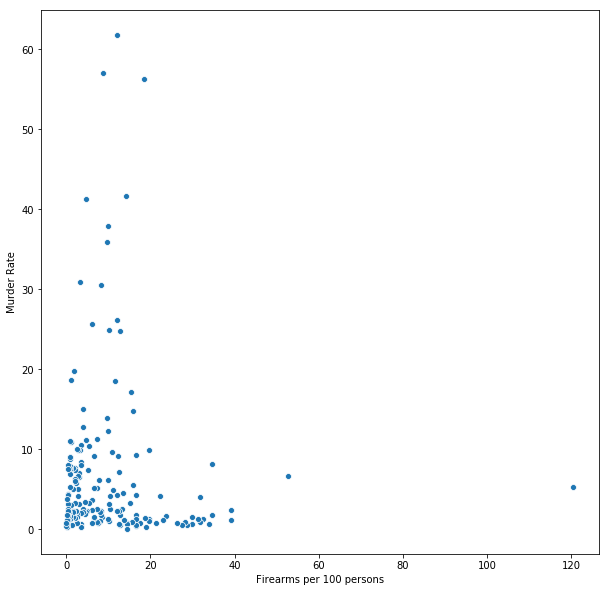

In [14]:
#Find a way to add make bubble plot, add annotation to scatter plot
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'Firearms per 100 persons', y = 'Murder Rate', data = finalDf)


**GDP per capita, firearms per 100 persons murder rate Bubble plot for developed countries (GDP per capita of at least $40000).**

In [16]:
population = finalDf['Population 2017'].tolist()
gdp = finalDf['GDP(US$million)'].tolist()
gdp[76] = '60043'
GDPcapita = []
for i in range(len(gdp)): 
    GDPcapita.append((int(gdp[i])*1000000)/(population[i]))
finalDf['GDP per capita'] = pd.Series(GDPcapita)

In [17]:
bubbleDf = finalDf[['Firearms per 100 persons','Murder Rate','GDP per capita','Country']]

In [18]:
newDf = bubbleDf[bubbleDf['GDP per capita'] > 40000]
newDf = newDf.reset_index()
newDf = newDf.drop(['index'],axis = 1)

**Note that its sometimes necessary to transform the variables in a data set and subset the data to certain groups to reveal new insights on the data set. For instance, the scatterplot above didn't really tell us the relationship between the murder rate and firearms per capita but after performing a log transformation on  the murder rate variable and subsetting it to only the wealthiest countries of the world, it was revealed there is a strong positive correlation between murder rate and firearms per capita when it comes to developed nations.**

**Note that it's sometimes neccesary to do background research on the data set to gain a better understanding on trends or outliers found in the data set. For instance, the U.S is a clear outlier in the Data set below. After looking at the data and doing some research, I discovered this was because most guns in the U.S are unregistered while the guns in the countries in the scatter plot below were registered. Further reading revealed that this was because the countries in the bubble plot below had strict gun control policies which either mandated all guns to be registered or had complex licensing requirements to purchase guns which hampered gun ownership in those countries.**

- https://en.wikipedia.org/wiki/Firearms_regulation_in_France
- https://en.wikipedia.org/wiki/Firearms_regulation_in_Finland
- https://www.loc.gov/law/help/firearms-control/singapore.php
- https://www.thenational.ae/uae/courts/abu-dhabi-shooting-rare-gun-incident-puts-spotlight-on-strict-licensing-laws-1.809198

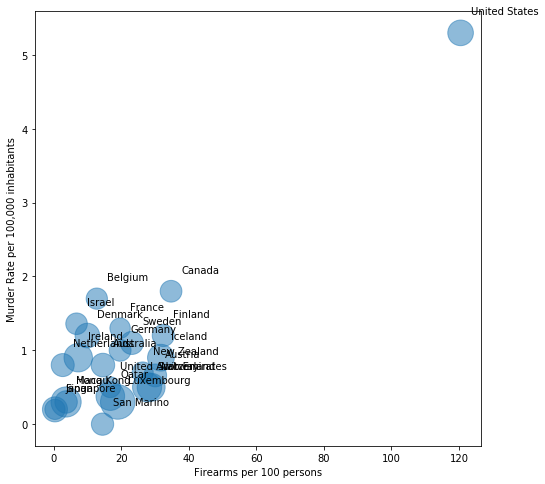

Correlation cofficient of 0.8584538274775171 suggests that in developed countries
The number of Guns of guns per capita and murder rate have a strong positive correlatation.


In [19]:
plt.figure(figsize=(8,8))
plt.scatter(x = newDf['Firearms per 100 persons'],
            y = newDf['Murder Rate'],
            s = [0.01*i for i in newDf['GDP per capita']],
           alpha = 0.5)
murderRate = newDf['Murder Rate'].tolist()
country = newDf['Country'].tolist() 
perCapita = newDf['GDP per capita']
firearms = newDf['Firearms per 100 persons']
for i in range(len(country)):
    plt.text((firearms[i] + 3),(murderRate[i] + 0.25),country[i])
plt.xlabel('Firearms per 100 persons')
plt.ylabel('Murder Rate per 100,000 inhabitants')
plt.show()
print("Correlation cofficient of",np.corrcoef(firearms,murderRate)[0,1],"suggests that in developed countries")
print("The number of Guns of guns per capita and murder rate have a strong positive correlatation.")


**GDP per capita, fire arms per 100 persons murder rate Bubble plot for less developed countries (GDP per capita below $1000)**

In [20]:
newDf = bubbleDf[bubbleDf['GDP per capita'] < 1000]
newDf = newDf.reset_index()
newDf = newDf.drop(['index'],axis = 1)

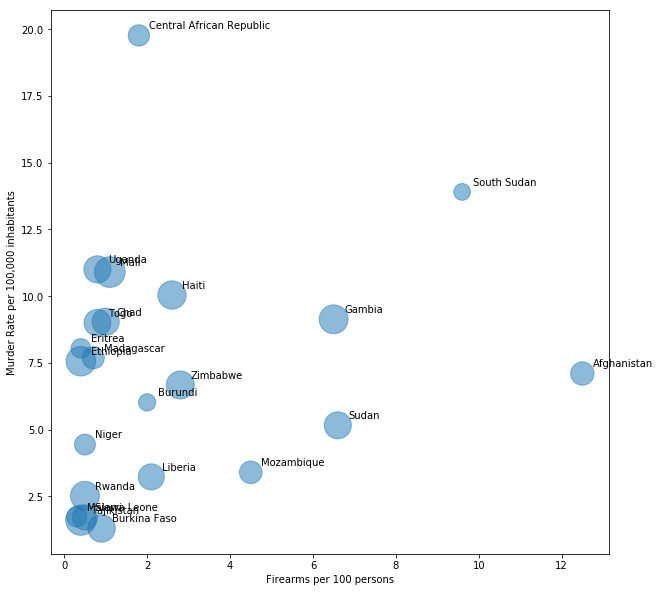

Correlation cofficient of 0.21921516383477319 suggests that in less developed countries,
The number of Guns of guns per capita and murder rate have a weak positive correlation


In [21]:
plt.figure(figsize=(10,10))
plt.scatter(x = newDf['Firearms per 100 persons'],
            y = newDf['Murder Rate'],
            s = [i for i in newDf['GDP per capita']],
           alpha = 0.5)
murderRate = newDf['Murder Rate'].tolist()
country = newDf['Country'].tolist() 
perCapita = newDf['GDP per capita']
firearms = newDf['Firearms per 100 persons']
plt.xlabel('Firearms per 100 persons')
plt.ylabel('Murder Rate per 100,000 inhabitants')
for i in range(len(country)):
    plt.text((firearms[i] + 0.25),(murderRate[i] + 0.25),country[i])
plt.show()
print("Correlation cofficient of",np.corrcoef(firearms,murderRate)[0,1],"suggests that in less developed countries,")
print("The number of Guns of guns per capita and murder rate have a weak positive correlation")

In [22]:
#Makes Data frame with Registered Firearms and unregistered firearms
fireArms = Draft[['Registered Firearms','Unregistered firearms','Country','Population 2017']]
joinedFirearms = pd.merge(fireArms,subsetData,on = 'Country')
joinedFirearms = pd.merge(joinedFirearms,GDP, on = 'Country')
analysisDf = joinedFirearms.dropna()
analysisDf = analysisDf.reset_index()
analysisDf = analysisDf.drop('index', axis=1)

In [23]:
#Makes new variable ratio
murder = analysisDf['Number of Intentional murders'].tolist()
registered = analysisDf['Registered Firearms'].tolist()
unregistered = analysisDf['Unregistered firearms'].tolist()
country = analysisDf['Country'].tolist()
ratio = []
logMurder = []
for i in range(len(registered)):
    logMurder.append(np.log(murder[i]))
    ratio.append(registered[i]/(unregistered[i] + registered[i]))
    #ratio.append(math.exp(registered[i]/(unregistered[i] + registered[i])))  
analysisDf['Ratio'] = pd.Series(ratio)
analysisDf['LogMurder'] = pd.Series(logMurder)


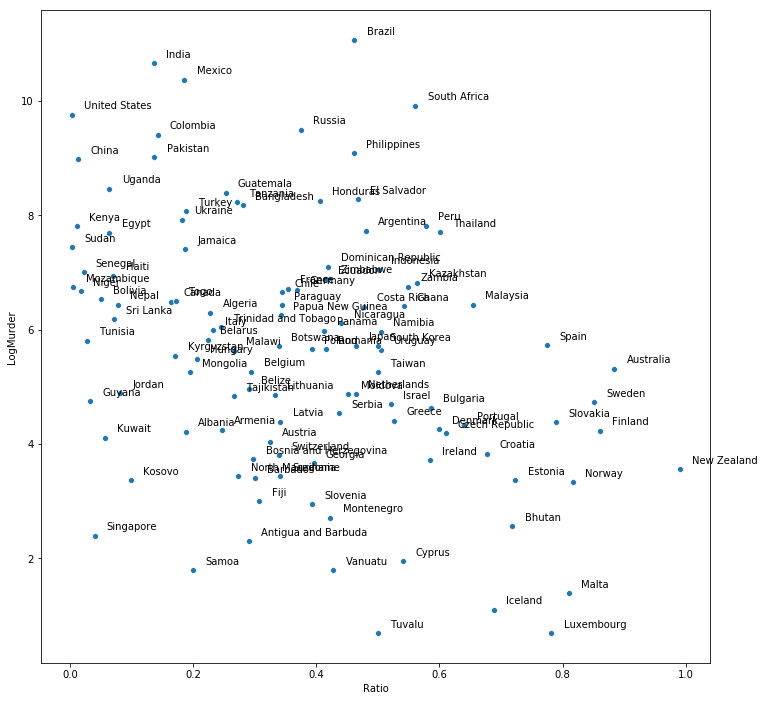

Correlation coefficient of -0.3525500760060146 Suggests there is a moderate negative correlation
between the proportion of registered guns and the number of intentional murders commited.


In [24]:
#Plots relationship between number of murders commited and ratio between Registered Firearms and Unregistered Firearms
plt.figure(figsize=(12,12))
sns.scatterplot(x = 'Ratio', y = 'LogMurder', data = analysisDf)
for i in range(len(country)):
    plt.text((ratio[i])+ 0.02,(logMurder[i] + 0.1),country[i])
plt.show()
print("Correlation coefficient of",np.corrcoef(ratio,logMurder)[0,1],"Suggests there is a moderate negative correlation")
print("between the proportion of registered guns and the number of intentional murders commited.")


In [25]:
population = analysisDf['Population 2017'].tolist()
GDP = analysisDf['GDP(US$million)'].tolist()
GDPcapita = []
for i in range(len(GDP)): 
    GDPcapita.append((int(GDP[i])*1000000)/(population[i]))
analysisDf['GDP per capita'] = pd.Series(GDPcapita)

In [26]:
bubbleDf = analysisDf[['Ratio','Murder Rate','GDP per capita','Country']]
newDf = bubbleDf[bubbleDf['GDP per capita'] > 35000]
newDf = newDf.reset_index()
newDf = newDf.drop(['index'],axis = 1)

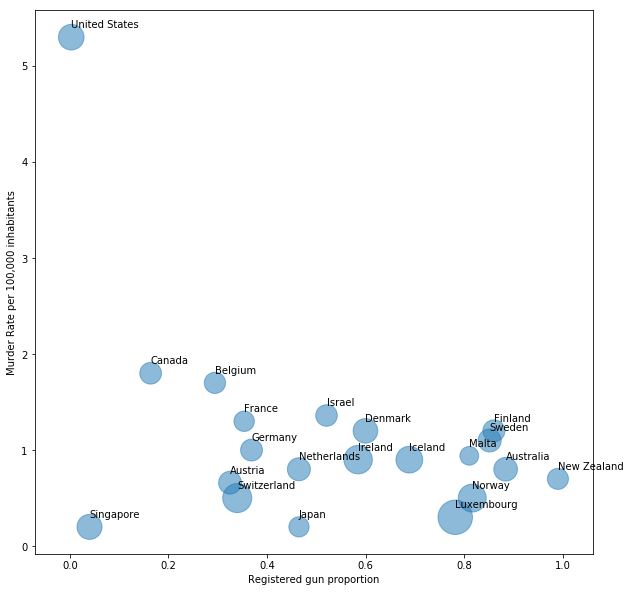

Correlation cofficient of -0.4316340570724945 suggests that in developed countries
the proportion of registered guns and murder rate have a moderate inverse correlation.


In [27]:
plt.figure(figsize=(10,10))
plt.scatter(x = newDf['Ratio'],
            y = newDf['Murder Rate'],
            s = [0.01*i for i in newDf['GDP per capita']],
           alpha = 0.5)
murderRate = newDf['Murder Rate'].tolist()
country = newDf['Country'].tolist() 
perCapita = newDf['GDP per capita']
ratio = newDf['Ratio']
for i in range(len(country)):
    plt.text((ratio[i]) ,(murderRate[i]+ 0.1),country[i])
plt.xlabel('Registered gun proportion')
plt.ylabel('Murder Rate per 100,000 inhabitants')
plt.show()
print("Correlation cofficient of",np.corrcoef(ratio,murderRate)[0,1],"suggests that in developed countries")
print("the proportion of registered guns and murder rate have a moderate inverse correlation.")


# Conclusion

**The EDA and correlation coefficients above showed that there is an overall positive correlation between the number of firearms per capita of a country and 'it's murder rate. Closer examination revealed that there is a negative correlation between the proportion of registered guns in a country and it's murder rate. The EDA also revealed that wealthier countries tended to have lower crime rates when compared to poorer nations suggesting that the economic well being of a country has an effect on it's murder rate.**

**Based on research, one plausible reason that the U.S has a significantly higher murder rate than other developed nation is because of gun availability. It is much easier to obtain a gun in the U.S when compared to other developed nations which often has restrictive gun ownership laws. The avaliability of firearms especially among criminals makes it more likely that criminal activity such as robbery end in fatalities if the situation gets tense, such as when a robber is caught.**
- https://www.vox.com/2015/8/27/9217163/america-guns-europe

**One take away from this assignment is that to get a better understanding on the story the data set is trying to tell, it's helpful to do some background research on trends and outliers of the data set and its sometimes necessary to create new variables from existing columns of the data set.**